### 2024/02/20 座標数の外れ値を解析

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches

In [2]:
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)

In [3]:
# 箱ひげ図を作成する
def boxviolinplot(plot_list, label, ymin, ymax):
    title = ''
    plt.rcParams['font.family'] = 'MS Gothic'
    FIG_WIDTH = 15
    FIG_HEIGHT = 7
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), facecolor='white')
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    ax.set_xticklabels(label)

    ax.set_title(title)
    
    # ax.boxplot(plot_list, whis=(0, 100))
    # ax.boxplot(plot_list, whis=(5, 95))
    
    ax.boxplot(plot_list, whis=1.5)
    
    # ax.violinplot(plot_list)
    
    plt.show()
    plt.close()
    return

In [4]:
coord_size = pd.read_csv('../temp/coord_size_alldrawing.csv', index_col=0)

In [5]:
coord_size_each = pd.read_pickle('../temp/20240216_coordsize.pkl')

##### ▶重複なし座標数 全体の分布

##### ▶極端な外れ値の線を見てみる

In [6]:
sorted_coord_size = sorted(coord_size['coord_sizes_remove_overlap'].to_list(), reverse=True)
percent_len = int(len(sorted_coord_size) /100 * 1)
coord_size_trim1per = sorted_coord_size[percent_len:-percent_len]

max_trim1per = max(coord_size_trim1per)

print('トリム1% 最大値：', max_trim1per)

トリム1% 最大値： 83


##### ▶座標数が1000を超えるストロークを描画

In [13]:
# URLを指定したドローイングの、指定した順番のストロークの形状を描画する関数
def draw_stroke(url, rotate_type, drawing_id, stroke_id, path):
    class PreprocessedData():
        def __init__(self, url, rotate_type):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            self.df_remove_overlap = None
            
            self.url = url
            self.rotate_type = rotate_type
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            self.remove_overlap_coord()
            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
        
        # 重複している座標を排除
        def remove_overlap_coord(self):
            df = self.df_mm.copy()
            
            org_ptxs = df['ptx_mm']
            org_ptys = df['pty_mm']
            remove_indexs = []
            for ptxs, ptys in zip(org_ptxs, org_ptys):
                remove_index = []
                for i in range(1, len(ptxs)):
                    if ptxs[i] == ptxs[i-1] and ptys[i] == ptys[i-1]:
                        remove_index.append(i)
                    else:
                        pass
                remove_indexs.append(remove_index)
            
            df['remove_index'] = remove_indexs
            
            remove_overlap_ptxs = []
            remove_overlap_ptys = []
            for ptxs, ptys, remove_index in zip(org_ptxs, org_ptys, df['remove_index']):
                remove_overlap_ptx = [ ptxs[i] for i in range(len(ptxs)) if i not in remove_index]
                remove_overlap_pty = [ ptys[i] for i in range(len(ptys)) if i not in remove_index]
                remove_overlap_ptxs.append(remove_overlap_ptx)
                remove_overlap_ptys.append(remove_overlap_pty)    
            
            df['ptx_mm'] = remove_overlap_ptxs
            df['pty_mm'] = remove_overlap_ptys
            
            self.df_remove_overlap = df

    # --- グラフ描画 ---#
    data = PreprocessedData(url, rotate_type)
    df = data.df_remove_overlap
    
    STROKE_COLOR = 'black'
    STROKE_WIDTH = 1
    FIG_WIDTH = 10
    FIG_HEIGHT = 10
    
    
    plt.rcParams['font.family'] = 'MS Gothic'
    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), facecolor='white')
    
    x = df.query('stroke_id == @stroke_id')['ptx_mm'].iloc[-1]
    y = df.query('stroke_id == @stroke_id')['pty_mm'].iloc[-1]
    
    ax.plot(x, y, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
    ax.scatter(x, y, color=STROKE_COLOR, marker='.')
    
    title = f'{drawing_id}_{stroke_id}_coordsize-{len(x)}'
    ax.set_title(title)
    # plt.savefig(f'{path}/{drawing_id}_{stroke_id}.png')
    plt.show()
    plt.close()
    return

In [15]:
# drawing_id_outlier = []
# stroke_id_outlier = []

# for drawing_id, csizes in zip(coord_size_each['drawing_id'], coord_size_each['coordsize_rm_overlap']):
#     for i, csize in enumerate(csizes):
#         if 50 < csize and csize <= 100:
#             drawing_id_outlier.append(drawing_id)
#             stroke_id_outlier.append(i)

# for did, sid in zip(drawing_id_outlier[:50], stroke_id_outlier[:50]):
#     url = drawing_info.query('drawing_id == @did')['url'].iloc[-1]
#     rotate_type = drawing_info.query('drawing_id == @did')['rotate_type'].iloc[-1]
#     draw_stroke(url, rotate_type, did, sid, '../temp/20240229_coordsize_50-100')
#     print(did, sid)

In [81]:
# for did, sid in zip(drawing_id_outlier, stroke_id_outlier):
#     url = drawing_info.query('drawing_id == @did')['url'].iloc[-1]
#     rotate_type = drawing_info.query('drawing_id == @did')['rotate_type'].iloc[-1]
#     draw_stroke(url, rotate_type, did, sid)
#     print(did, sid)

##### ▶座標数の最頻値は 6

In [95]:
from scipy import  stats
mode = stats.mode(coord_size['coord_sizes_remove_overlap'].to_list())
# coord_size.describe()
mode

C:\Users\ispec\AppData\Local\Temp\ipykernel_9796\3938143907.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(coord_size['coord_sizes_remove_overlap'].to_list())


ModeResult(mode=array([6]), count=array([254186]))

##### ▶対数変換してみる

下側 : 0.5929253245799998
上側 : 72.24370324363558


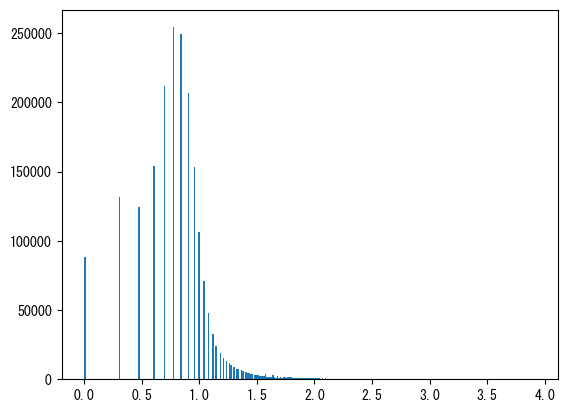

In [133]:
log_csize = [math.log10(csize)for csize in coord_size['coord_sizes_remove_overlap'].to_list()]
log_mean = round(sum(log_csize) / len(log_csize), 4)
log_std = stats.tstd(log_csize, ddof=0)

log_mean3std = [csize for csize in log_csize if (csize <= log_mean + 3 * log_std)]

# boxviolinplot(log_mean3std, '', 0, 4)
plt.hist(log_csize, bins=200)

print(f'下側 : {10 ** (round(log_mean - 3 * log_std, 4))}')
print(f'上側 : {10 ** (round(log_mean + 3 * log_std, 4))}')

##### ▶対数変換 + mean3stdの結果、「72」を座標数の最大値とする

##### ▶描画者ごとの座標数の調査

In [ ]:
coord_size_each = pd.read_pickle('../temp/20240216_coordsize.pkl')

### 2024/03/04 座標数とストロークの長さの相関を調査

##### ▶相関なし!

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches

In [29]:
df_csize_len = pd.read_csv('../temp/20240305coordsize_length_alldrawing.csv', index_col=0).query('coord_sizes_remove_overlap <= 100')

In [16]:
# FIG_WIDTH = 10
# FIG_HEIGHT = 10
# fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), facecolor='white')
# ax.scatter(df_csize_len['coord_sizes_remove_overlap'], df_csize_len['length_mm'], marker='.', color='green')

##### ▶座標数のヒストグラム

(array([1.31866e+05, 1.24276e+05, 1.53946e+05, 2.11793e+05, 2.54186e+05,
        2.49129e+05, 2.06500e+05, 1.53453e+05, 1.06062e+05, 7.10830e+04,
        4.75840e+04, 3.26970e+04, 2.38920e+04, 1.89650e+04, 1.55180e+04,
        1.32360e+04, 1.18180e+04, 1.00970e+04, 8.89400e+03, 7.70700e+03,
        7.12700e+03, 6.38400e+03, 5.61700e+03, 5.10300e+03, 4.82600e+03,
        4.29200e+03, 3.89400e+03, 3.59300e+03, 3.32900e+03, 3.12700e+03,
        2.84500e+03, 2.59500e+03, 2.47600e+03, 2.43000e+03, 2.29800e+03,
        2.06600e+03, 1.97100e+03, 1.80300e+03, 1.74600e+03, 1.66100e+03,
        1.53800e+03, 1.50600e+03, 1.38500e+03, 1.33400e+03, 1.24200e+03,
        1.21400e+03, 1.14000e+03, 1.10000e+03, 1.05300e+03, 0.00000e+00,
        9.04000e+02, 9.74000e+02, 9.44000e+02, 9.01000e+02, 8.61000e+02,
        7.84000e+02, 7.90000e+02, 7.47000e+02, 6.79000e+02, 7.59000e+02,
        6.69000e+02, 6.85000e+02, 6.07000e+02, 5.90000e+02, 5.80000e+02,
        5.77000e+02, 5.50000e+02, 5.62000e+02, 5.30

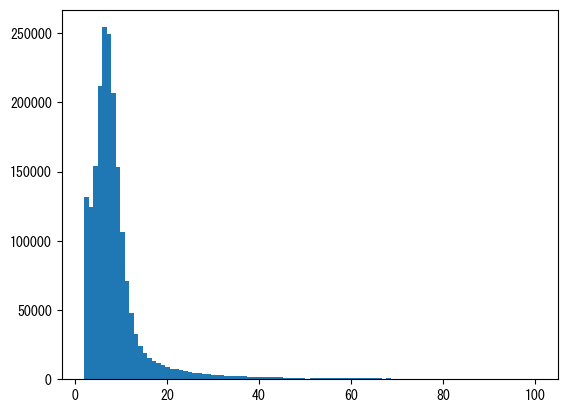

In [35]:
min_size = 2
max_size = 100
plt.hist([val for val in coord_size['coord_sizes_remove_overlap'] if val <= max_size and val >= min_size], bins=100)

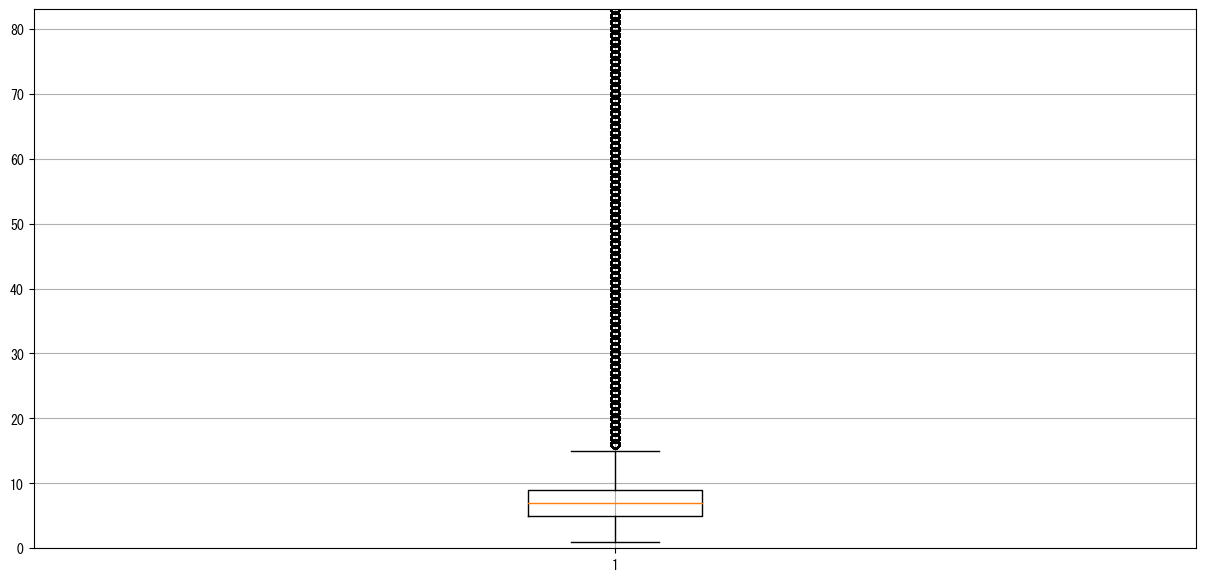

In [20]:
boxviolinplot(coord_size['coord_sizes_remove_overlap'], '', 0, 83)